In [1]:
import requests
import pandas as pd

from pandasql import sqldf
from sklearn import datasets

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pysqldf = lambda q: sqldf(q, globals())

In [3]:
df = pd.DataFrame()
skip = 0

while True:
    link = f"https://olinda.bcb.gov.br/olinda/servico/taxaJuros/versao/v2/odata/TaxasJurosMensalPorMes?$top=10000&$skip={skip}&$format=json"
    data = requests.get(link)
    data = data.json()
    df_uppdate = pd.DataFrame(data["value"])
    if data["value"] == []:
        break
    df = pd.concat([df, df_uppdate])
    skip += 10000

In [4]:
df.columns = [x.lower() for x in df.columns]
df.rename(columns={"instituicaofinanceira":"banco", "taxajurosaomes":"jurosmensal", "taxajurosaoano":"jurosanual", "anomes":"data"}, inplace=True)

In [5]:
df.drop(labels="mes", axis = 1, inplace=True)

In [6]:
df["data"] = pd.to_datetime(df["data"], format="%Y-%m")

In [7]:
df.drop(["posicao", "cnpj8"], axis=1, inplace=True)

In [71]:
# Obtendo o ano a partir da coluna data:
df["ano"] = pd.DatetimeIndex(df['data']).year

In [72]:
df.head()

,modalidade,banco,jurosmensal,jurosanual,data,ano
0,FINANCIAMENTO IMOBILIÁRIO COM TAXAS REGULADAS ...,CAIXA ECONOMICA FEDERAL,0.80,10.05,2022-09-01,2022
1,FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO...,CAIXA ECONOMICA FEDERAL,0.79,9.91,2022-09-01,2022
2,FINANCIAMENTO IMOBILIÁRIO COM TAXAS REGULADAS ...,BCO SANTANDER (BRASIL) S.A.,0.97,12.34,2022-09-01,2022
3,FINANCIAMENTO IMOBILIÁRIO COM TAXAS REGULADAS ...,BCO DO EST. DE SE S.A.,0.00,0.00,2022-09-01,2022
4,FINANCIAMENTO IMOBILIÁRIO COM TAXAS REGULADAS ...,APE POUPEX,0.36,4.38,2022-09-01,2022


In [21]:
df.modalidade.unique()

array(['FINANCIAMENTO IMOBILIÁRIO COM TAXAS REGULADAS - PRÉ-FIXADO',
       'FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO - PRÉ-FIXADO',
       'FINANCIAMENTO IMOBILIÁRIO COM TAXAS REGULADAS - PÓS-FIXADO REFERENCIADO EM TR',
       'FINANCIAMENTO IMOBILIÁRIO COM TAXAS REGULADAS - PÓS-FIXADO REFERENCIADO EM IPCA',
       'FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO - PÓS-FIXADO REFERENCIADO EM TR',
       'FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO - PÓS-FIXADO REFERENCIADO EM IPCA'],
      dtype=object)

In [78]:
query = """
        SELECT
            *
        FROM
            df
        WHERE
            "banco" == "CAIXA ECONOMICA FEDERAL" AND
            "modalidade" == "FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO - PRÉ-FIXADO"
        GROUP BY
            "data"

"""

In [79]:
result = pysqldf(query)
result.head()

,modalidade,banco,jurosmensal,jurosanual,data,ano
0,FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO...,CAIXA ECONOMICA FEDERAL,0.72,9.02,2020-04-01 00:00:00.000000,2020
1,FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO...,CAIXA ECONOMICA FEDERAL,0.75,9.36,2020-08-01 00:00:00.000000,2020
2,FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO...,CAIXA ECONOMICA FEDERAL,1.07,13.56,2021-03-01 00:00:00.000000,2021
3,FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO...,CAIXA ECONOMICA FEDERAL,0.93,11.80,2021-04-01 00:00:00.000000,2021
4,FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO...,CAIXA ECONOMICA FEDERAL,1.07,13.62,2021-05-01 00:00:00.000000,2021


<AxesSubplot:xlabel='data', ylabel='jurosanual'>

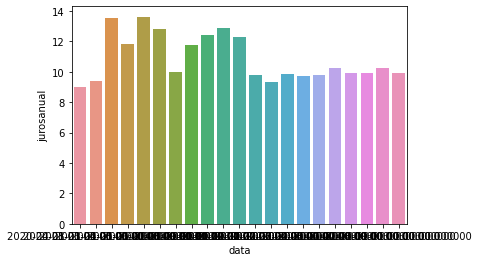

In [80]:
sns.barplot(y = result["jurosanual"], x = result["data"])

In [81]:
query = """
        SELECT
            AVG(jurosanual) AS juros_anual,
            ano
        FROM
            df
        WHERE
            "banco" == "CAIXA ECONOMICA FEDERAL" AND
            "modalidade" == "FINANCIAMENTO IMOBILIÁRIO COM TAXAS DE MERCADO - PRÉ-FIXADO"
        GROUP BY
            ano
"""

In [82]:
result = pysqldf(query)
result

,juros_anual,ano
0,9.190000,2020
1,12.097000,2021
2,9.884444,2022


<AxesSubplot:xlabel='ano', ylabel='juros_anual'>

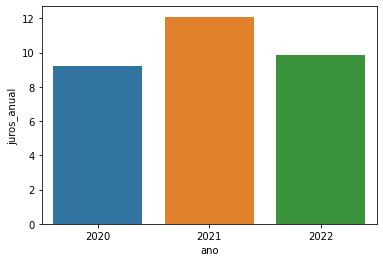

In [83]:
sns.barplot(y = result["juros_anual"], x = result["ano"])